# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST

As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains
images of handwritten digits. You can view the first number of examples by
changing `show_n_images`.

In [5]:
# !sudo pip3 install -U matplotlib==2.0.2

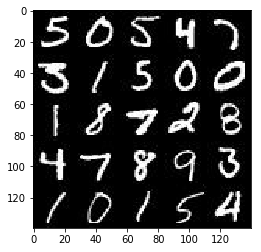

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA

The [CelebFaces Attributes Dataset
(CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains
over 200,000 celebrity images with annotations. Since you're going to be
generating faces, you won't need the annotations. You can view the first number
of examples by changing `show_n_images`.

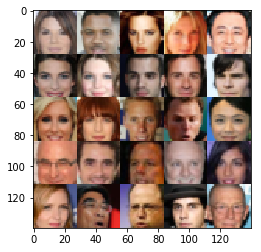

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(
    glob(os.path.join(
        data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data

Since the project's main focus is on building the GANs, we'll preprocess the
data for you. The values of the MNIST and CelebA dataset will be in the range of
-0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to
remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color
channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the
CelebA images have [3 color channels (RGB color
channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network

You'll build the components necessary to build a GANs by implementing the
following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU

This will check to make sure you have the correct version of TensorFlow and
access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input

Implement the `model_inputs` function to create TF Placeholders for the Neural
Network. It should create the following placeholders:

- Real input images placeholder with rank 4 using `image_width`, `image_height`,
  and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images,
tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_placeholder = tf.placeholder(
        shape=(None, image_width, image_height, image_channels), dtype=tf.float32)
    z_placholder = tf.placeholder(shape=(None, z_dim), dtype=tf.float32)
    learning_rate = tf.placeholder(dtype=tf.float32)
    return image_placeholder, z_placholder, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that
discriminates on `images`. This function should be able to reuse the variables
in the neural network. Use
[`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope)
with a scope name of "discriminator" to allow the variables to be reused. The
function should return a tuple of (tensor output of the discriminator, tensor
logits of the discriminator).

In [59]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)        
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x3 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)        
        relu3 = tf.maximum(alpha * bn3, bn3)
    
        # Flatten it
        flat = tf.keras.layers.Flatten()(relu3)
        # hidden = tf.layers.dense(flat, 128)
        # hidden = tf.maximum(alpha*hidden, hidden)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator

Implement `generator` to generate an image using `z`. This function should be
able to reuse the variables in the neural network. Use
[`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope)
with a scope name of "generator" to allow the variables to be reused. The
function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=4, strides=1)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # x3 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        # x3 = tf.layers.batch_normalization(x3, training=is_train)
        # x3 = tf.maximum(alpha * x3, x3)
        
        # x3 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        # x3 = tf.layers.batch_normalization(x3, training=is_train)
        # x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [58]:
def model_loss(input_real, input_z, output_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=0.9*tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    model_input_args = data_shape[1:] + (z_dim, )
    input_real, input_z, input_learning_rate = model_inputs(*model_input_args)
    output_chanel_dim = 3 if data_image_mode == 'RGB' else 1
    d_loss, g_loss = model_loss(input_real, input_z, output_chanel_dim)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 40 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, 24, input_z, output_chanel_dim,
                                          data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, 24, input_z, output_chanel_dim, data_image_mode)

    # with open('samples.pkl', 'wb') as f:
    #     pkl.dump(samples, f)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0103... Generator Loss: 5.1781
Epoch 1/2... Discriminator Loss: 0.0127... Generator Loss: 13.8779
Epoch 1/2... Discriminator Loss: 6.4052... Generator Loss: 19.2145
Epoch 1/2... Discriminator Loss: 0.0113... Generator Loss: 9.3016
Epoch 1/2... Discriminator Loss: 4.9783... Generator Loss: 19.3381


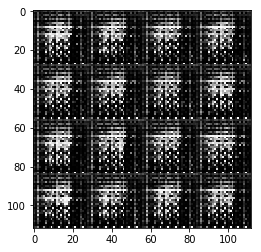

Epoch 1/2... Discriminator Loss: 0.1333... Generator Loss: 3.1327
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 1.8970
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 1.8754
Epoch 1/2... Discriminator Loss: 0.1812... Generator Loss: 2.8131
Epoch 1/2... Discriminator Loss: 0.1597... Generator Loss: 2.3368


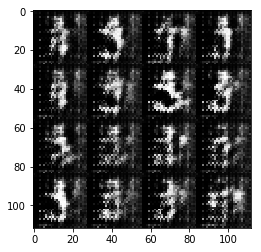

Epoch 1/2... Discriminator Loss: 0.3979... Generator Loss: 1.7246
Epoch 1/2... Discriminator Loss: 0.1460... Generator Loss: 2.2926
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 9.8524
Epoch 1/2... Discriminator Loss: 0.0828... Generator Loss: 4.1245
Epoch 1/2... Discriminator Loss: 1.7316... Generator Loss: 0.2955


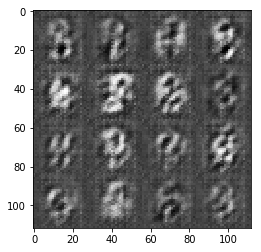

Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 1.1865
Epoch 1/2... Discriminator Loss: 0.0356... Generator Loss: 5.0950
Epoch 1/2... Discriminator Loss: 0.4414... Generator Loss: 1.4290
Epoch 1/2... Discriminator Loss: 0.1911... Generator Loss: 2.7308
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.7043


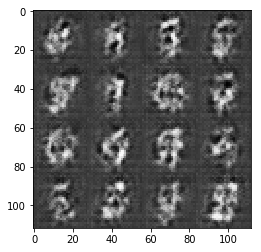

Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.3603
Epoch 1/2... Discriminator Loss: 3.0054... Generator Loss: 0.0696
Epoch 1/2... Discriminator Loss: 0.2192... Generator Loss: 2.2594
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 10.1111
Epoch 1/2... Discriminator Loss: 9.1312... Generator Loss: 14.7401


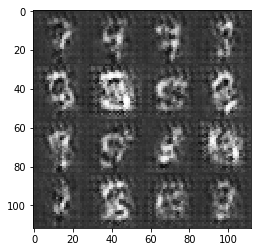

Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 0.2969... Generator Loss: 2.1869
Epoch 1/2... Discriminator Loss: 0.1237... Generator Loss: 3.0133
Epoch 1/2... Discriminator Loss: 0.0351... Generator Loss: 4.2099
Epoch 1/2... Discriminator Loss: 0.0025... Generator Loss: 7.8324


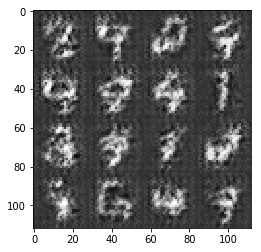

Epoch 1/2... Discriminator Loss: 0.0231... Generator Loss: 4.6498
Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 9.7799
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.4973
Epoch 1/2... Discriminator Loss: 1.9494... Generator Loss: 0.2305
Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 1.0451


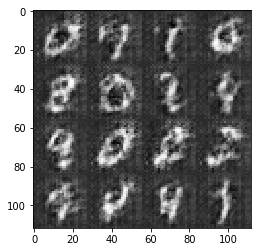

Epoch 1/2... Discriminator Loss: 0.1233... Generator Loss: 3.3112
Epoch 1/2... Discriminator Loss: 0.0904... Generator Loss: 5.7075
Epoch 1/2... Discriminator Loss: 0.1715... Generator Loss: 2.7487
Epoch 1/2... Discriminator Loss: 0.0679... Generator Loss: 3.6635
Epoch 1/2... Discriminator Loss: 0.0311... Generator Loss: 4.0677


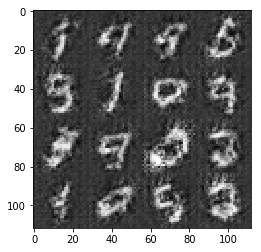

Epoch 1/2... Discriminator Loss: 0.0115... Generator Loss: 6.3301
Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 7.0597
Epoch 1/2... Discriminator Loss: 0.0051... Generator Loss: 6.9699
Epoch 1/2... Discriminator Loss: 0.5392... Generator Loss: 1.6485
Epoch 1/2... Discriminator Loss: 0.3226... Generator Loss: 2.3346


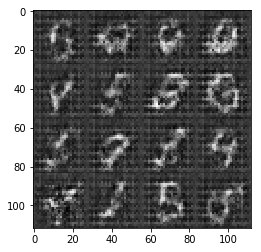

Epoch 1/2... Discriminator Loss: 0.2506... Generator Loss: 2.0079
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 3.9359
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.2320
Epoch 2/2... Discriminator Loss: 0.0147... Generator Loss: 6.2405
Epoch 2/2... Discriminator Loss: 0.2944... Generator Loss: 2.0504


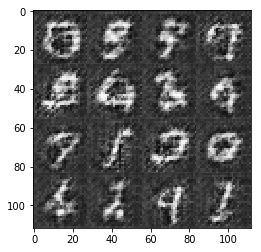

Epoch 2/2... Discriminator Loss: 0.4713... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 0.1068... Generator Loss: 2.7516
Epoch 2/2... Discriminator Loss: 0.2780... Generator Loss: 1.8352
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 7.5527
Epoch 2/2... Discriminator Loss: 0.1510... Generator Loss: 2.8808


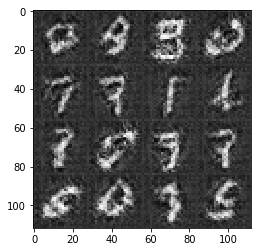

Epoch 2/2... Discriminator Loss: 0.3023... Generator Loss: 1.6621
Epoch 2/2... Discriminator Loss: 0.0971... Generator Loss: 3.0743
Epoch 2/2... Discriminator Loss: 0.0198... Generator Loss: 5.1527
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 8.5783
Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 3.9209


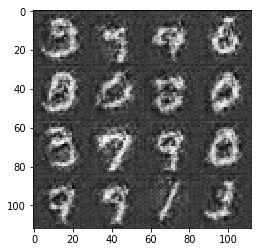

Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 4.4805
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 4.2190
Epoch 2/2... Discriminator Loss: 0.0037... Generator Loss: 8.4280
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 9.3273
Epoch 2/2... Discriminator Loss: 0.0060... Generator Loss: 6.0535


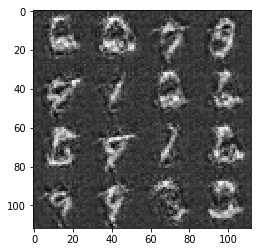

Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 8.2443
Epoch 2/2... Discriminator Loss: 0.0013... Generator Loss: 8.3911
Epoch 2/2... Discriminator Loss: 0.0013... Generator Loss: 7.4554
Epoch 2/2... Discriminator Loss: 0.0095... Generator Loss: 5.7062
Epoch 2/2... Discriminator Loss: 0.3957... Generator Loss: 3.1328


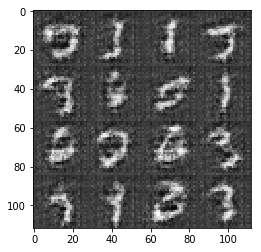

Epoch 2/2... Discriminator Loss: 0.1437... Generator Loss: 3.9077
Epoch 2/2... Discriminator Loss: 0.1432... Generator Loss: 7.8370
Epoch 2/2... Discriminator Loss: 0.0612... Generator Loss: 5.1481
Epoch 2/2... Discriminator Loss: 0.2580... Generator Loss: 2.1149
Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 4.4004


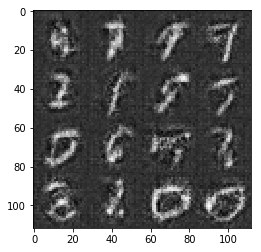

Epoch 2/2... Discriminator Loss: 0.1726... Generator Loss: 2.7982
Epoch 2/2... Discriminator Loss: 0.0717... Generator Loss: 7.0509
Epoch 2/2... Discriminator Loss: 0.0250... Generator Loss: 6.2229
Epoch 2/2... Discriminator Loss: 0.0105... Generator Loss: 5.5683
Epoch 2/2... Discriminator Loss: 0.0017... Generator Loss: 8.2039


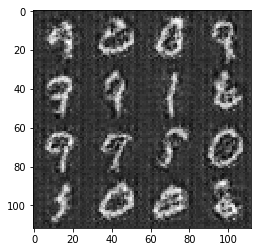

Epoch 2/2... Discriminator Loss: 0.1789... Generator Loss: 2.4099
Epoch 2/2... Discriminator Loss: 0.1039... Generator Loss: 4.0349
Epoch 2/2... Discriminator Loss: 0.1025... Generator Loss: 3.6389
Epoch 2/2... Discriminator Loss: 0.3106... Generator Loss: 1.7971
Epoch 2/2... Discriminator Loss: 0.0186... Generator Loss: 4.8643


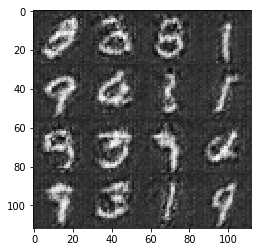

Epoch 2/2... Discriminator Loss: 0.8056... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 0.0898... Generator Loss: 4.7724
Epoch 2/2... Discriminator Loss: 0.1804... Generator Loss: 2.5110
Epoch 2/2... Discriminator Loss: 0.1679... Generator Loss: 2.5169
Epoch 2/2... Discriminator Loss: 2.0740... Generator Loss: 0.2859


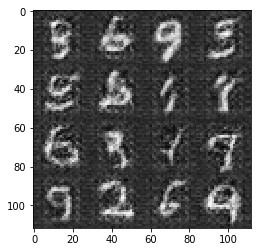

Epoch 2/2... Discriminator Loss: 0.3233... Generator Loss: 1.7142
Epoch 2/2... Discriminator Loss: 0.2157... Generator Loss: 2.1837
Epoch 2/2... Discriminator Loss: 0.0264... Generator Loss: 4.0754


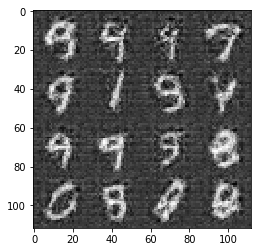

In [51]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.keras.backend.set_learning_phase(1)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 5.2106
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 5.6617
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.3672
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.6324


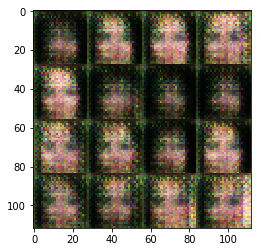

Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.8110
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 2.9033
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 3.7131
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 3.8848
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 2.5961


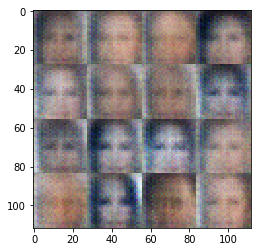

Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 2.5241
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 3.3966
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 4.6585
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 5.3635


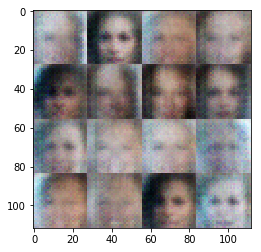

Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.7343
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 6.1779
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 6.4695
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 6.2426
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 5.7787


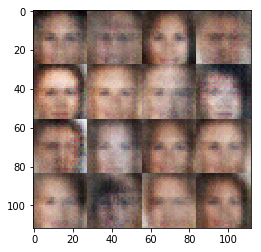

Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 8.8876
Epoch 1/1... Discriminator Loss: 2.0928... Generator Loss: 6.1822
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 6.7332
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.9465
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 9.0365


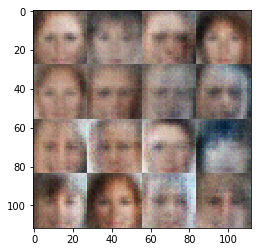

Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 11.3176
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 7.3920
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 7.1341
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 1.8842
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.9870


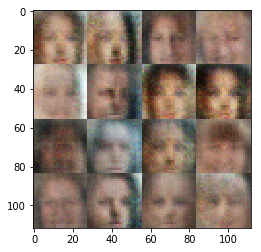

Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.8488
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 4.1511
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 5.3239
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 2.4923
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 2.9681


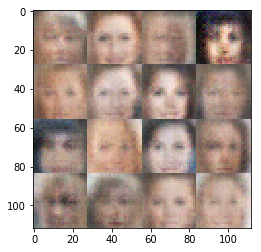

Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 7.9458
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 4.7236
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 5.2513
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 5.7231


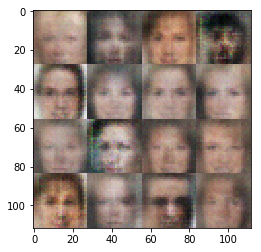

Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 9.9118
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.0585
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 3.6695
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 6.4841
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 6.1216


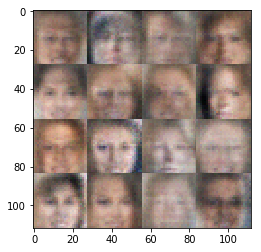

Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 8.3325
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 8.9652
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 3.6200
Epoch 1/1... Discriminator Loss: 0.3296... Generator Loss: 11.0083
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 9.6698


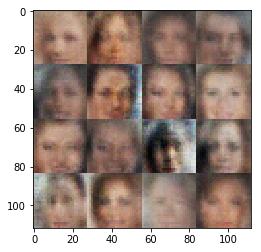

Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 6.3085
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 6.5309
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 8.0803
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 8.0145
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 3.6114


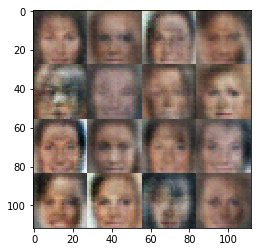

Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 6.6284
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 5.3288
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 6.8766
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 4.6112
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 11.3351


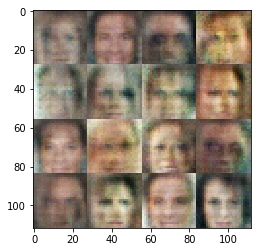

Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 8.2628
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 7.6084
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 11.7201
Epoch 1/1... Discriminator Loss: 2.1550... Generator Loss: 5.3398
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 6.6044


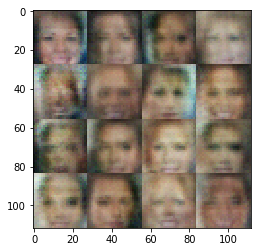

Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 2.6602
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 7.8960
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 9.4420
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 4.9524
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 10.0019


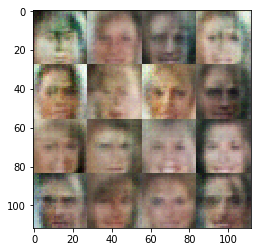

Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 7.9336
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 4.1425
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 11.6766
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 8.9145
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 5.9475


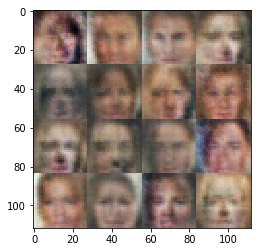

Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 4.7465
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 4.5581
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 2.6085
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 6.2750


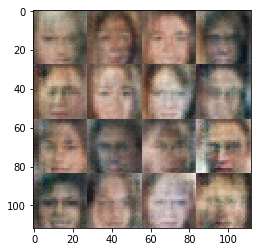

In [61]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.